In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-preprocessed/english_preprocessed (1).csv
/kaggle/input/hindi-preprocessed/hindi_preprocessed_2.csv
/kaggle/input/d/sanketp0023/marathi-preprocessed/marathi_preprocessed.csv


**Import Necessary Libraries**

In [2]:
import pandas as pd
import torch
from datasets import Dataset
from tqdm import tqdm

In [3]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorWithPadding,
)

2024-05-02 17:27:59.500504: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 17:27:59.500611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 17:27:59.628301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Function For Building Prompt and Predicting**

In [4]:
class prompting:

        def __init__(self, model="flant5"):
            if model == "flant5":
                self.checkpoint = "google/flan-t5-large"
            else:
                raise Exception("Select one of the following models: flant5 or mt0")
            
            self.tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(self.checkpoint, torch_dtype="auto", device_map="auto")
            
        def build_prompt(self, prompt_template: str, output_indicator: str, input_text: str):
            if prompt_template:
                prompt = f"{prompt_template} {input_text} {output_indicator}"
            else:
                raise NotImplementedError("Insert a template")
            return prompt

        def predict(self, prompt_template: str, output_indicator: str, data):
            with torch.no_grad():

                if isinstance(data, str):
                    texts = [self.build_prompt(prompt_template, output_indicator, data)]
                elif isinstance(data, pd.DataFrame):
                    texts = data['text'].tolist()
                    texts = [self.build_prompt(prompt_template, output_indicator, t) for t in texts]
                elif isinstance(data, list) and all(isinstance(t, str) for t in data):
                    texts = [self.build_prompt(prompt_template, output_indicator, t) for t in data]
                else:
                    raise ValueError('Input data must be either a string or a pandas DataFrame.')

                raw_dataset = Dataset.from_dict({"text": texts})

                proc_dataset = raw_dataset.map(
                    lambda x: self.tokenizer(
                        x["text"], truncation=True
                    ),  # truncate by default to maximum model length
                    batched=True,
                    load_from_cache_file=False,
                    desc="Running tokenizer on dataset",
                    remove_columns=["text"],
                )
                
                proc_dataset.set_format("torch")

                loader = torch.utils.data.DataLoader(
                    proc_dataset,
                    shuffle=False,
                    batch_size=16, #default
                    collate_fn=DataCollatorWithPadding(self.tokenizer),
                )

                predictions = []
                for i, batch in tqdm(
                    enumerate(loader), desc=self.checkpoint, total=len(texts) // 512
                ):
                    inputs = {k: v.to(self.model.device) for k, v in batch.items()}
                    outputs = self.model.generate(**inputs)

                    decoded = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
                    predictions.extend(decoded)

                predictions =  list(map(str.lower, predictions))
            return predictions

# Predicting On English Dataset

In [5]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.read_csv('/kaggle/input/english-preprocessed/english_preprocessed (1).csv')
print(df.head())

                                                                                                                                                                                                                                        text  \
0                                                    if you made it through this were not only able to start making money for yourself but sustain living that way all from home fuck these company corporate pig power to the people always   
1                                                                                                                                                                                 technically that is still turning back the clock dick head   
2  and you are the govt stop thinking about world medium liberal gang or any optic whatsoever and act now already if this is what a person at your level is facing then shudder to think the plight of common people in bengal bengalburning   
3                                       

In [6]:
# Step 1: Initialize the prompting class instance
prompter = prompting(model="flant5")  

# Step 2: Prepare your DataFrame with text and labels
data = df[['text', 'label']]

#Step 3: Initialize prompt template 
prompt_template = """Classify this text as hate or non-hate.
The definition of hate speech is ‘Hate speech’ is
speech that attacks a person or group on the basis
of attributes such as race, religion, ethnic origin,
national origin, sex, disability, sexual orientation,
or gender identity.
   Text:"""
output_indicator = "Answer:"

# Step 4: Call the predict method of the prompting class
predictions = prompter.predict(prompt_template=prompt_template, output_indicator=output_indicator, data=data)

# Now predictions contains the generated predictions based on the input data

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Running tokenizer on dataset:   0%|          | 0/8693 [00:00<?, ? examples/s]

google/flan-t5-large:   0%|          | 0/16 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
google/flan-t5-large: 544it [10:00,  1.10s/it]                       


In [7]:
# Convert predictions from string to binary format
predicted_labels = [0 if label == 'hate' else 1 for label in predictions]


In [8]:
true_labels = data['label'].tolist()

**Calculate results**

In [9]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro') 
print("F1 Score:", f1)

F1 Score: 0.7757719802490972


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4635
           1       0.75      0.79      0.77      4058

    accuracy                           0.78      8693
   macro avg       0.78      0.78      0.78      8693
weighted avg       0.78      0.78      0.78      8693



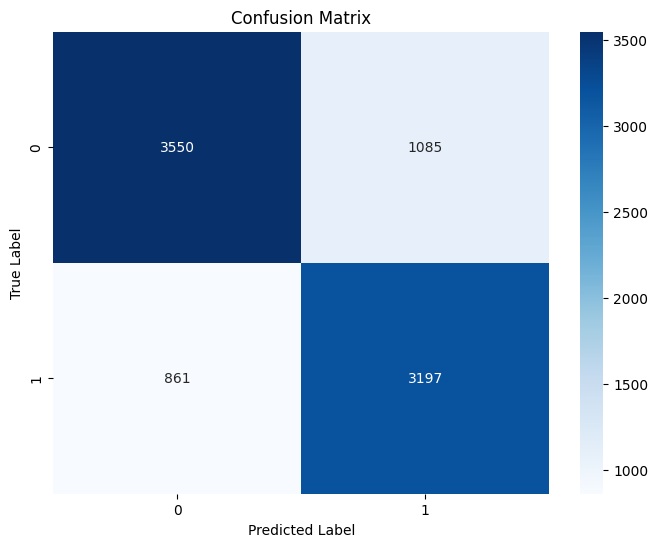

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Classification Report:")
print(report)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


**Prompt containing examples of Hate Speech**

In [11]:
# Step 1: Initialize the prompting class instance
prompter2 = prompting(model="flant5")  

# Step 2: Prepare your DataFrame with text and labels
data = df[['text', 'label']]

#Step 3: Initialize prompt template 
prompt_template = """Classify this text as hate or non-hate.
The definition of hate speech is ‘Hate speech’ is
speech that attacks a person or group on the basis
of attributes such as race, religion, ethnic origin,
national origin, sex, disability, sexual orientation,
or gender identity.Examples:
1. Text: "bitch what"
   Answer: Hate
2. Text: "technically that is still turning back the clock dick head"
   Answer: Hate
3. Text: "fuck off this is you"
   Answer: Hate
   Text:"""
output_indicator = "Answer:"

# Step 3: Call the predict method of the prompting class
predictions2 = prompter2.predict(prompt_template=prompt_template, output_indicator=output_indicator, data=data)

# Now predictions contains the generated predictions based on the input data

Running tokenizer on dataset:   0%|          | 0/8693 [00:00<?, ? examples/s]

google/flan-t5-large:   0%|          | 0/16 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
google/flan-t5-large: 544it [13:50,  1.53s/it]                       


In [12]:
# Convert predictions from string to binary format
predicted_labels = [0 if label == 'hate' else 1 for label in predictions2]


In [13]:
true_labels = data['label'].tolist()

**Calculate results**

In [14]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro') 
print("F1 Score:", f1)

F1 Score: 0.782768293568978


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      4635
           1       0.77      0.77      0.77      4058

    accuracy                           0.78      8693
   macro avg       0.78      0.78      0.78      8693
weighted avg       0.78      0.78      0.78      8693



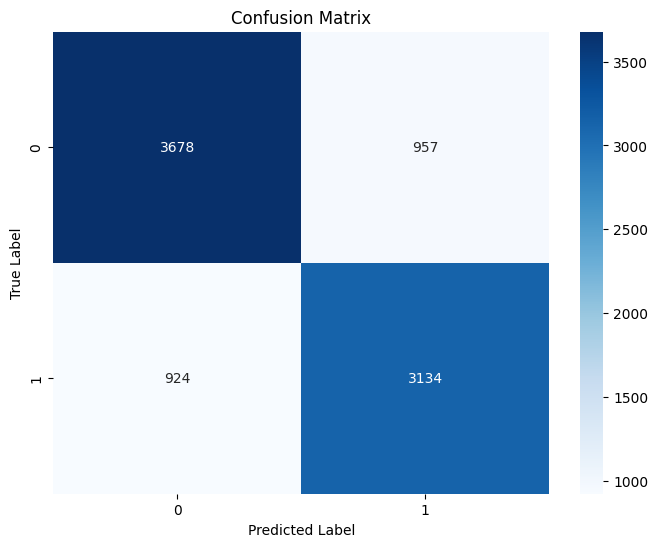

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Classification Report:")
print(report)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# On Marathi Data

In [16]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  # Show all columns
df2 = pd.read_csv('/kaggle/input/d/sanketp0023/marathi-preprocessed/marathi_preprocessed.csv')
print(df2.head())

                                                                                                     tweet  \
0          आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन भाजपचे तत्कालीन…   
1             कुणी कविता करत असतं कुणी कविता जगत असतं कुणी कविता वाचत असतं कुणाला कविताच वाचवत असते पल्लवी   
2             आम्हाला इतिहासातील औरंगजेबशी घेणे आमच्या कडे आमचा बेकायदेशीर रित्या आलेला हक्काचा औरंगजेब क…   
3                गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट भाषणात मोठे शब्द वापरणे ऐकले कृती करावी उद्योग भी…   
4  कब्झा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब होऊन प्रदर्शित जर ह्या चित्रपटाला चांगला प्रतिसाद मिळाला आप…   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  


In [17]:
df2.rename(columns={'tweet': 'text'}, inplace=True)

In [18]:
# Step 1: Initialize the prompting class instance
prompter = prompting(model="flant5")  

# Step 2: Prepare your DataFrame with text and labels

data = df2[['text', 'label']]



**english + marathi prompt with hate examples**

In [19]:
prompt_template = """Classify this text as hate or non-hate.
The definition of hate speech is ‘Hate speech’ is
speech that attacks a person or group on the basis
of attributes such as race, religion, ethnic origin,
national origin, sex, disability, sexual orientation,
or gender identity.Examples:
1. Text: "काही लोकांना सांगून उपयोग नाही त्यांच्या गुडघ्यात मेंदू आहे"
   Answer: hate
2. Text: "भिकारचोट पत्रकार दलाल साले"
   Answer: hate
3. Text: "बावळट लोकं सत्ताधारी पक्षात अपेक्षा करणार"
   Answer: hate
4. Text:"लवड्या अगोदरच रडायला लागलास तू"
   Answer:hate
Text:"
"""
output_indicator = "Answer:"


# Step 3: Call the predict method of the prompting class
predictions = prompter.predict(prompt_template=prompt_template, output_indicator=output_indicator, data=data)

# Now predictions contains the generated predictions based on the input data


Running tokenizer on dataset:   0%|          | 0/3519 [00:00<?, ? examples/s]

google/flan-t5-large:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
google/flan-t5-large: 220it [05:47,  1.58s/it]                     


In [20]:
# Convert predictions from string to binary format
predicted_labels = [0 if label == 'hate' else 1 for label in predictions]


In [21]:
true_labels = data['label'].tolist()

In [22]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro') 
print("F1 Score:", f1)

F1 Score: 0.40224222863937487


**complete prompt in marathi with hate examples**

In [23]:
prompt_template = """हा मजकूर द्वेष किंवा द्वेष नसलेला म्हणून वर्गीकृत करा.
द्वेषयुक्त भाषणाची व्याख्या ‘हेट स्पीच’ अशी आहे
एखाद्या व्यक्तीवर किंवा गटाच्या आधारावर हल्ला करणारे भाषण
वंश, धर्म, वांशिक मूळ,
राष्ट्रीय मूळ, लिंग, अपंगत्व, लैंगिक प्रवृत्ती,
किंवा लिंग ओळख. उदाहरणे:
1. मजकूर: "काही लोकांना सांगून उपयोग नाही त्यांच्या गुडघ्यात मेंदू आहे"
   उत्तर: द्वेष
2. मजकूर: "भिकारचोट पत्रकार दलाल साले"
   उत्तर: द्वेष
3. मजकूर: "बावळट लोकं सत्ताधारी पक्षाची अपेक्षा करणार"
   उत्तर: द्वेष
4. मजकूर: "लवड्या अगोदरच रडायला लागलास तू"
   उत्तर: द्वेष
मजकूर:"""
output_indicator = " उत्तर:"


# Step 3: Call the predict method of the prompting class
predictions = prompter.predict(prompt_template=prompt_template, output_indicator=output_indicator, data=data)


Running tokenizer on dataset:   0%|          | 0/3519 [00:00<?, ? examples/s]

google/flan-t5-large:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
google/flan-t5-large: 220it [17:16,  4.71s/it]                     


In [24]:
# Convert predictions from string to binary format
predicted_labels = [0 if label == 'hate' else 1 for label in predictions]


In [25]:
true_labels = data['label'].tolist()

In [26]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro') 
print("F1 Score:", f1)

F1 Score: 0.40224222863937487


# On Hindi Data

In [27]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  # Show all columns
df2 = pd.read_csv('/kaggle/input/hindi-preprocessed/hindi_preprocessed_2.csv')
print(df2.head())

                                                                                                                                                       text  \
0                                                          dying        liars i warned  yrs back  banned by sardar patel ignored ेरनहींभेड़ियापाललियाभक्तो    
1  सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम आदमी को सिलेंडर और कन्सेंट्रेटर ख़ुद से ही ख़रीदना पड़ रहा है  तो पैसे कहाँ जा रहे हैं बीयर्ड ऑयल में       
2                                                                                 शेरए सिवान शहाबुद्दीन साहब से रिश्ता क्या لا إله إلا الله محمد رسول الله    
3                                                                                                                            आसमानी किताब के नाजायज औलाद है   
4                              इसे कहते हैं दोगला पंती जिस सपा की दम पर  से  का सफर किया और माया अपनी इज्ज़त बचा पाई आज उसी सपा को मिटाने की बात कर रही हैं   

   task_1  
0       1  
1       1  
2       1

In [28]:
df2.rename(columns={'task_1': 'label'}, inplace=True)

In [29]:
# Step 1: Initialize the prompting class instance
prompter = prompting(model="flant5")  

# Step 2: Prepare your DataFrame with text and labels

data = df2[['text', 'label']]



In [30]:
prompt_template = """इस पाठ को घृणित या गैर-घृणित के रूप में वर्गीकृत करें।
घृणास्पद भाषण को 'घृणास्पद भाषण' के रूप में परिभाषित किया गया है
वह भाषण जो किसी व्यक्ति या समूह पर हमला करता हो
जाति, धर्म, जातीय मूल,
राष्ट्रीय मूल, लिंग, विकलांगता, यौन रुझान,
या लिंग पहचान. उदाहरण:
1. पाठ: "कुछ लोगों को यह बताने का कोई फायदा नहीं है कि उनका दिमाग घुटनों में है"
   उत्तर: नफरत
2. पाठ: "बिल्कुल सत्य ऐसे गद्दारों ने ही देश को बर्बाद कर दिया"
   उत्तर: नफरत
3. पाठ: "बिल्कुल सत्य ऐसे गद्दारों ने ही देश को बर्बाद कर दिया"
   उत्तर: नफरत
4. पाठ: "बिकाऊ मीडिया"
   उत्तर: नफरत
5. पाठ:"ये हरामी शिक्षक नहीं शिक्षक के नाम पर कलंक है सालों को फांसी से कम सजा नहीं होनी चाहिए"
   उत्तर: नफरत
 पाठ:"""
output_indicator = " उत्तर:"
# Step 3: Call the predict method of the prompting class
predictions = prompter.predict(prompt_template=prompt_template, output_indicator=output_indicator, data=data)


Running tokenizer on dataset:   0%|          | 0/4594 [00:00<?, ? examples/s]

google/flan-t5-large:   0%|          | 0/8 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
google/flan-t5-large: 288it [39:20,  8.20s/it]                     


In [31]:
# Convert predictions from string to binary format
predicted_labels = [0 if label == 'hate' else 1 for label in predictions]


In [32]:
true_labels = data['label'].tolist()

In [33]:
from sklearn.metrics import f1_score
# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro') 
print("F1 Score:", f1)

F1 Score: 0.40760799484203736
